In [1]:
import numpy as np
import random
from gym.spaces import Discrete
import torch 
from collections import deque
import copy
from IPython.display import clear_output



using gpu 2


In [2]:
device = "cuda" if not torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Move maken

In [3]:
def legal_move(x,y,z,veld,size):
    #max hoogte
    if z > size[2] - 1:
        return False 
    
    #buiten lot
    if x < 0 or x >= size[0] or y < 0 or y >= size[1]:
        return False 
    
    #staat al een container
    if veld[x][y][z] != 0:
        return False
    
    #container zweeft niet
    if not veld[x][y][:z].all() != 0:
        return False 
    
    #container in het midden 
    if y-1 != -1 and y+1 != size[1]:
        if veld[x][y-1][0] != 0 and veld[x][y+1][0] != 0:
            return False 
    
    return True  

In [4]:
def action_number_to_xyz(action,size):
    waarde = action + 1
    
    for a in range(size[0] + 1):
        if waarde <= a * (size[1] * size[2]):
            x = a - 1
            break 

    waarde_y = waarde - (x * size[1] * size[2])

    for i in range(waarde_y + 1):
        if waarde_y <= i * (size[2]):
            y = i - 1
            break

    z = waarde_y - y * size[2] - 1

    return x,y,z

In [5]:
def place_container(action, prio, speelveld,size):

    x,y,z = action_number_to_xyz(action,size)
    
    if legal_move(x,y,z,speelveld,size):
        speelveld[x][y][z] = prio
        return True, speelveld
    else:
        return False, speelveld

# Environment

In [6]:
class Environment():

    def __init__(self,size):
        self.size = size
        self.action_space = Discrete(int(self.size[0]*self.size[1]*self.size[2]))
        self.observation_space = speelveld.flatten()
        self.state = self.reset()
        self.poging = 0
        self.toegestande_action = []

    def step(self,action,prio):
        
        if type(self.state) == tuple:
            self.state = self.state[1]
        
        iets = place_container(action,prio,self.state.reshape(self.size),self.size)
        
        if iets[0]:
            reward = 1
            self.poging = 0
            self.toegestande_action.append(action)
            
        else:
            reward = -1
            self.poging += 1
            
        if (self.state == 0).sum() == 0:
            reward += 10
        self.state = iets[1].flatten()
        return self.state.astype(int), reward, self.state

    def reset(self):
        self.state = np.array([([( [[0] * self.size[2]]) * self.size[1] ]) * self.size[0] ]).astype(object).flatten()
        self.reward = 0
        self.poging = 0
        return self.reward, self.state

    def game_over(self):
        
        #alle containers geplaatst of niet mogelijk container plaatsen 
        aantal_nul = (self.state == 0).sum()

        if aantal_nul == 0 or self.poging >= int(self.size[0]*self.size[1]*self.size[2]) or self.poging >= aantal_nul:
            return True
        return False
    
    def state_(self):
        return self.state
    def action_state_(self):
        return self.action_space
    def toegestande_action_def(self):
        return self.toegestande_action
    

# agent


In [7]:
class myAgent():
    def __init__(self, env):
        self.total_rewards = 0
        self.env = env
        self.state_history = []
    
    def steps(self,action):   
        
        actie = self.env.step(action , 1)  

        #reward krijgen 
        self.total_rewards += actie[1]
        return actie
    
    def reset(self):
        self.total_rewards = 0
        return self.total_rewards
    
    def update_history(self, state, reward):
        self.state_history.append((state, reward))
    
    def game_reward(self):
        return self.total_rewards

# neuraal netwerk

In [22]:
# https://github.com/NandaKishoreJoshi/Reinforcement_Lerning/blob/main/RL_course/Ch3_Gridworld/Part%203%20-%20Deep%20Q-learning%20for%20GridWorld%20-%20Complete%20code.ipynb
#model lagen

size =(2,2,2)
containers = size[0]*size[1]*size[2]

l1 = containers
l2 = 128
l3 = 256
l4 = containers

sync_freq = 50 
learning_rate = 0.00005

epochs = 1500
gamma = 0.9
mem_size = 300
batch_size = 128
h = 0
sync_freq = 500 #A
j=0

epsilon = 1
min_epsilon = 0.01
epsilon_afnemen = 0.04
wanneer_epsilon = 50


a = epochs// 100
waarde_laten_zien = a

In [23]:


model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
 
model2 = model2 = copy.deepcopy(model)        
model2.load_state_dict(model.state_dict())    
                               
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# trainen

In [24]:
losses = [] #A
speelveld = np.array([([( [[0] * size[2]]) * size[1] ]) * size[0] ]).astype(object)
enviroment = Environment(size)
game_scores = []
stappen = []
agent = myAgent(enviroment)

replay = deque(maxlen=mem_size)
epsilon_ja = False 
for i in range(epochs):
    
    #state opvragen/resetten en torch van maken
    state_ = np.array(enviroment.reset()[1]).astype(int) + np.random.rand(1,containers)/100.0
    state1 = torch.from_numpy(state_).float()
    agent.reset()

    while not enviroment.game_over():
        j+=1
        qval = model(state1)
        qval_ = qval.data.numpy()
        
        
        if (random.random() < epsilon): 
            action_ = enviroment.action_space.sample()
        else:
            action_ = np.argmax(qval_)
        next_state, reward, iets = agent.steps(action_)
    
    
        state2_ = np.array(enviroment.state_()).astype(int) + np.random.rand(1,containers)/10.0
        state2 = torch.from_numpy(state2_).float() 
        done = True if not enviroment.game_over() else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch) #B
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

            if j % sync_freq == 0: 
                model2.load_state_dict(model.state_dict())
    
    game_rewards = agent.game_reward()
    game_scores.append(game_rewards)
    
    #waardes laten zien 
    if i % (waarde_laten_zien) == 0:
        print( int((i/epochs) * 100),"%",epsilon)
        clear_output(wait=True) 
    
    #epsilon laten afnemen na een bepaald aantal keer (hyperparameter)
    if epsilon_ja == False:
        if i % (wanneer_epsilon) == 0:
            if (epsilon - epsilon_afnemen) >= min_epsilon -min_epsilon * 0.1:
                epsilon= epsilon - epsilon_afnemen
            else:
                epsilon_ja == True 
    
  
losses = np.array(losses)   

99 % 0.039999999999999654


In [11]:
#imports plot

#import torch.nn as nn
#from scipy.interpolate import make_interp_spline
#import matplotlib.pyplot as plt
#from collections import Counter

from matplotlib import pylab as plt
from numpy import median

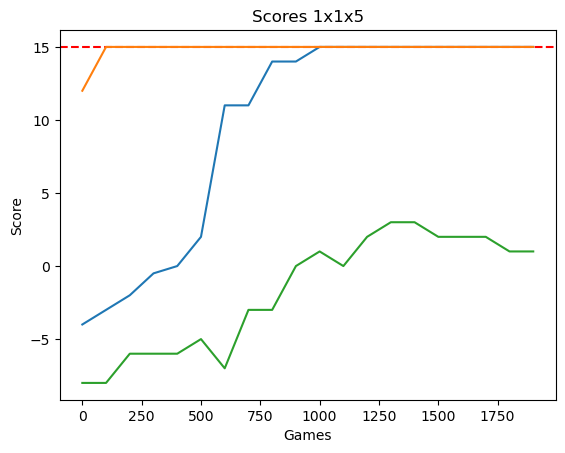

In [13]:
median_scores= []
max_scores= []
min_scores= []

chunks = [game_scores[x:x+100] for x in range(0, len(game_scores), 100)]
for i in chunks:
    median_scores.append(median(i))
    max_scores.append(max(i))
    min_scores.append(min(i))
x = [i*100 for i in range(int(epochs/100))]
plt.plot(x,median_scores)
plt.axhline(y=15, color='r', linestyle='--')
plt.plot(x,max_scores)
plt.plot(x,min_scores)
plt.title("Scores 1x1x5")
plt.xlabel("Games")
plt.ylabel("Score")
plt.show()

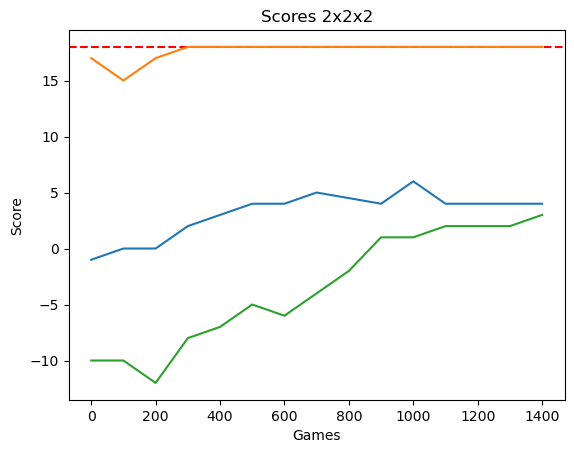

In [25]:
median_scores= []
max_scores= []
min_scores= []

chunks = [game_scores[x:x+100] for x in range(0, len(game_scores), 100)]
for i in chunks:
    median_scores.append(median(i))
    max_scores.append(max(i))
    min_scores.append(min(i))
x = [i*100 for i in range(int(epochs/100))]
plt.plot(x,median_scores)
plt.axhline(y=18, color='r', linestyle='--')
plt.plot(x,max_scores)
plt.plot(x,min_scores)
plt.title("Scores 2x2x2")
plt.xlabel("Games")
plt.ylabel("Score")
plt.show()

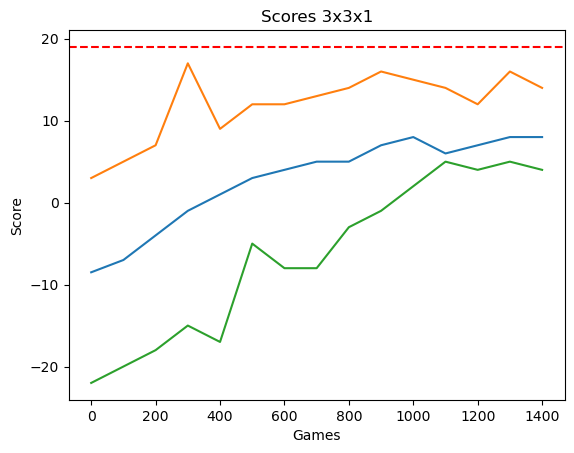

In [22]:
median_scores= []
max_scores= []
min_scores= []

chunks = [game_scores[x:x+100] for x in range(0, len(game_scores), 100)]
for i in chunks:
    median_scores.append(median(i))
    max_scores.append(max(i))
    min_scores.append(min(i))
x = [i*100 for i in range(int(epochs/100))]
plt.plot(x,median_scores)
plt.axhline(y=19, color='r', linestyle='--')
plt.plot(x,max_scores)
plt.plot(x,min_scores)
plt.title("Scores 3x3x1")
plt.xlabel("Games")
plt.ylabel("Score")
plt.show()

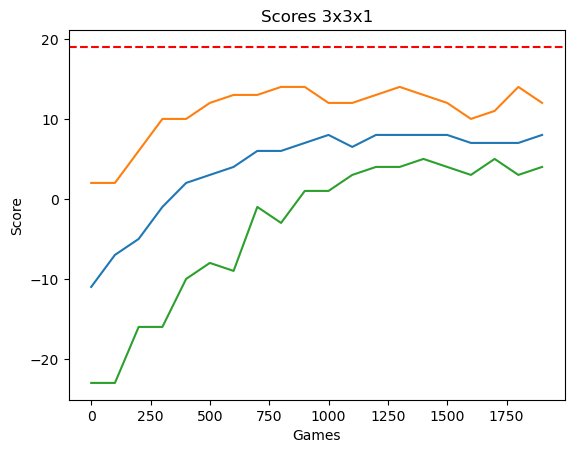

In [27]:
median_scores= []
max_scores= []
min_scores= []

chunks = [game_scores[x:x+100] for x in range(0, len(game_scores), 100)]
for i in chunks:
    median_scores.append(median(i))
    max_scores.append(max(i))
    min_scores.append(min(i))
x = [i*100 for i in range(int(epochs/100))]
plt.plot(x,median_scores)
plt.axhline(y=19, color='r', linestyle='--')
plt.plot(x,max_scores)
plt.plot(x,min_scores)
plt.title("Scores 3x3x1")
plt.xlabel("Games")
plt.ylabel("Score")
plt.show()

In [ ]:
chunks